## Library

In [ ]:
!pip install bpemb
!pip install gensim
!python -m spacy download en_core_web_sm
!pip install mpld3
!pip install datasets

In [2]:
import torch
import collections
import random
import numpy as np
from torch import nn
from bpemb import BPEmb
import pandas as pd
from transformers import BertTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForMaskedLM
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

## Dataset Loading

In [3]:
dataset = load_dataset("coastalcph/tydi_xor_rc")
train_set = dataset["train"]
validation_set = dataset["validation"]
df = pd.DataFrame(train_set)
df_eval = pd.DataFrame(validation_set)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/6.87M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15326 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3028 [00:00<?, ? examples/s]

# Language_Models_For_question

## Tokezination_Fi_Ru_Ja

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_question(row):
    if row['lang'] in ['fi', 'ru', 'ja']:
        return tokenizer.tokenize(row['question'])
    else:
        return None

df['tokens'] = df.apply(tokenize_question, axis=1)
df_eval['tokens'] = df_eval.apply(tokenize_question, axis=1)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### tokenizer display

In [23]:
df.head(3000)

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens
0,উইকিলিকস কত সালে সর্বপ্রথম ইন্টারনেটে প্রথম তথ...,WikiLeaks () is an international non-profit or...,bn,True,182,2006,None,None
1,দ্বিতীয় বিশ্বযুদ্ধে কোন দেশ পরাজিত হয় ?,The war in Europe concluded with an invasion o...,bn,True,48,Germany,None,None
2,মার্কিন যুক্তরাষ্ট্রের সংবিধান অনুযায়ী মার্কিন...,Same-sex marriage in the United States expande...,bn,False,-1,no,None,None
3,আরব-ইসরায়েলি যুদ্ধে আরবের মোট কয়জন সৈন্যের মৃ...,The exact number of Arab casualties is unknown...,bn,True,39,unknown,None,None
4,বিশ্বে প্রথম পুঁজিবাদী সমাজ কবে গড়ে ওঠে ?,"As Thomas Hall (2000) notes, ""The Sung Empire ...",bn,True,1219,17th century,None,None
...,...,...,...,...,...,...,...,...
2995,オンラインゲームの起源はいつ？,The history of online games dates back to the ...,ja,True,200,1978,None,"[オ, ##ン, ##ライン, ##ゲーム, ##の, 起, 源, は, ##い, ##つ, ？]"
2996,唐は中国統一した？,The Tang dynasty (; ) or the Tang Empire was a...,ja,False,-1,no,None,"[唐, は, 中, 国, 統, 一, した, ？]"
2997,ルッキズムにより訴訟に発展した事例はある？,Lookism is discriminatory treatment toward peo...,ja,False,-1,no,None,"[ル, ##ッ, ##キ, ##ズ, ##ム, ##に, ##より, 訴, 訟, に, 発,..."
2998,カーダール・ヤーノシュは虐殺を実行したことがある？,"In 1962, six years after the Hungarian Revolut...",ja,False,-1,no,None,"[カ, ##ー, ##ダー, ##ル, ・, ヤ, ##ー, ##ノ, ##シ, ##ュ, ..."


In [24]:
df_eval.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens
0,ఒరెగాన్ రాష్ట్రంలోని అతిపెద్ద నగరం ఏది ?,Portland is the largest city in the U.S. state...,te,True,0,Portland,None,None
1,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,"The word cholera is from ""kholera"" from χολή ""...",te,True,99,Indian subcontinent,None,None
2,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,Since it became widespread in the 19th century...,te,True,451,England,None,None
3,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,World War I occurred from 1914 to 1918. In ter...,te,True,26,1914,None,None
4,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,"World War I (often abbreviated as WWI or WW1),...",te,True,155,28 July 1914,None,None


## Dataset of Finnish language

In [25]:
fi_train_df = df[df['lang'] == 'fi']

fi_val_df = df_eval[df_eval['lang'] == 'fi']

fi_train_df.head()


,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens
9137,Mitkä olivat Rooman alkuvaiheet?,"In historiography, ancient Rome is Roman civil...",fi,True,0,"In historiography, ancient Rome is Roman civil...",None,"[Mit, ##kä, olivat, Rooma, ##n, al, ##ku, ##va..."
9138,Kuka oli toisen maailmansodan jälkeisen sosial...,Rákosi had difficulty managing the economy and...,fi,True,187,Mátyás Rákosi,None,"[Ku, ##ka, oli, toisen, maailmansodan, j, ##äl..."
9139,Mikä oli roomalaisten antama nimi nykyisen Unk...,Hungary in its modern (post-1946) borders roug...,fi,True,286,Pannonia,None,"[Mi, ##kä, oli, room, ##alaisten, ant, ##ama, ..."
9140,Kuinka monta ihmistä menehtyi Suezin kriisin a...,"On 25 January 1952, British forces attempted t...",fi,True,131,deaths of 41 Egyptians,None,"[Kui, ##nka, mont, ##a, ihm, ##istä, men, ##eh..."
9141,Millä vuosikymmenellä Yhdysvaltojen varhaishis...,The history of the United States began with th...,fi,True,87,"15,000 BC",None,"[Mill, ##ä, vu, ##osi, ##ky, ##mmen, ##ellä, Y..."


In [26]:
fi_val_df.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens
311,Missä maassa Jack Churchill syntyi?,"Churchill was born at Colombo, British Ceylon ...",fi,True,22,"Colombo, British Ceylon",None,"[Miss, ##ä, maa, ##ssa, Jack, Churchill, synty..."
312,Mikä on yleisin uskonto maailmassa?,The five largest religious groups by world pop...,fi,True,130,Christianity,None,"[Mi, ##kä, on, y, ##leis, ##in, us, ##kon, ##t..."
313,Kuka oli Glee sarjan pääosassa?,Rachel Barbra Berry (Lea Michele) is the lead ...,fi,True,0,Rachel Barbra Berry,None,"[Ku, ##ka, oli, Glee, sarjan, p, ##ää, ##osass..."
314,Milloin Killzone-sarjan peli julkaistiin ensim...,Killzone is a series of first-person shooter a...,fi,True,404,November 2004,None,"[Mill, ##oin, Kill, ##zone, -, sarjan, peli, j..."
315,Milloin Pennsylvania liitty USA?,The state is one of the 13 original founding s...,fi,True,404,"December 12, 1787",None,"[Mill, ##oin, Pennsylvania, li, ##itt, ##y, US..."


## Dataset for Russian language

In [27]:
ru_train_df = df[df['lang'] == 'ru']

ru_val_df = df_eval[df_eval['lang'] == 'ru']

## Dataset for Japanese Language

In [28]:
ja_train_df = df[df['lang'] == 'ja']

ja_val_df = df_eval[df_eval['lang'] == 'ja']

## Dataset Loader

In [29]:
class QuestionDataset(Dataset):
    def __init__(self, questions, tokens, tokenizer, max_length=128):
        self.questions = questions
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        input_ids = self.tokenizer.convert_tokens_to_ids(self.tokens[idx])
        attention_mask = [1] * len(input_ids)

        mask_idx = None
        if len(input_ids) > 1:
            mask_idx = torch.randint(0, len(input_ids), (1,)).item()
            input_ids[mask_idx] = self.tokenizer.mask_token_id

        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            input_ids += [0] * padding_length
            attention_mask += [0] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'masked_index': mask_idx
        }


## BERT_Model_For_Japanese_Language

In [30]:
train_dataset_ja = QuestionDataset(ja_train_df['question'].tolist(), ja_train_df['tokens'].tolist(), tokenizer)
val_dataset_ja = QuestionDataset(ja_val_df['question'].tolist(), ja_val_df['tokens'].tolist(), tokenizer)
train_dataloader_ja = DataLoader(train_dataset_ja, batch_size=8, shuffle=True)
val_dataloader_ja = DataLoader(val_dataset_ja, batch_size=8, shuffle=False)

In [31]:
model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')
model.train()
model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)


# Training Loop
for epoch in range(3):
    for batch in train_dataloader_ja:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()



model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings

In [32]:
model.eval()

def validate_model_ja(data_loader):
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for i in range(predictions.size(0)):
                for j in range(predictions.size(1)):
                    if input_ids[i][j] != 0:
                        total_tokens += 1
                        if predictions[i][j] == input_ids[i][j]:
                            total_correct += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return accuracy


validate_model_ja(val_dataloader_ja)

Validation Loss: 0.0279, Validation Accuracy: 0.9573


0.9573188198224004

## BERT_Model_For_Russian_Language

In [ ]:
train_dataset_ru = QuestionDataset(ru_train_df['question'].tolist(), ru_train_df['tokens'].tolist(), tokenizer)
val_dataset_ru = QuestionDataset(ru_val_df['question'].tolist(), ru_val_df['tokens'].tolist(), tokenizer)
train_dataloader_ru = DataLoader(train_dataset_ru, batch_size=8, shuffle=True)
val_dataloader_ru = DataLoader(val_dataset_ru, batch_size=8, shuffle=False)


In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')
model.train()
model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(3):
    for batch in train_dataloader_ru:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()


In [ ]:
model.eval()

def validate_model_ru(data_loader):
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for i in range(predictions.size(0)):
                for j in range(predictions.size(1)):
                    if input_ids[i][j] != 0:
                        total_tokens += 1
                        if predictions[i][j] == input_ids[i][j]:
                            total_correct += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return accuracy

validate_model_ru(val_dataloader_ru)

0.9459100957995579

## BERT_Model_For_Finnish_Language

In [ ]:
train_dataset_fi = QuestionDataset(fi_train_df['question'].tolist(), fi_train_df['tokens'].tolist(), tokenizer)
val_dataset_fi = QuestionDataset(fi_val_df['question'].tolist(), fi_val_df['tokens'].tolist(), tokenizer)
train_dataloader_fi = DataLoader(train_dataset_fi, batch_size=8, shuffle=True)
val_dataloader_fi = DataLoader(val_dataset_fi, batch_size=8, shuffle=False)

In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')
model.train()
model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_dataloader_fi:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()


In [ ]:
model.eval()

def validate_model_fi(data_loader):
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for i in range(predictions.size(0)):
                for j in range(predictions.size(1)):
                    if input_ids[i][j] != 0:
                        total_tokens += 1
                        if predictions[i][j] == input_ids[i][j]:
                            total_correct += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0

    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return accuracy

validate_model_fi(val_dataloader_fi)

0.9122529644268774

# Language_Model_For_context

## Context_Tokezination_Fi_Ru_Ja

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_context(row):
    if row['lang'] in ['fi', 'ru', 'ja']:
        return tokenizer.tokenize(row['context'])
    else:
        return None

df['context_tokens'] = df.apply(tokenize_context, axis=1)
df_eval['context_tokens'] = df_eval.apply(tokenize_context, axis=1)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### tokenizer display

In [34]:
df.head(3000)

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens,context_tokens
0,উইকিলিকস কত সালে সর্বপ্রথম ইন্টারনেটে প্রথম তথ...,WikiLeaks () is an international non-profit or...,bn,True,182,2006,None,None,None
1,দ্বিতীয় বিশ্বযুদ্ধে কোন দেশ পরাজিত হয় ?,The war in Europe concluded with an invasion o...,bn,True,48,Germany,None,None,None
2,মার্কিন যুক্তরাষ্ট্রের সংবিধান অনুযায়ী মার্কিন...,Same-sex marriage in the United States expande...,bn,False,-1,no,None,None,None
3,আরব-ইসরায়েলি যুদ্ধে আরবের মোট কয়জন সৈন্যের মৃ...,The exact number of Arab casualties is unknown...,bn,True,39,unknown,None,None,None
4,বিশ্বে প্রথম পুঁজিবাদী সমাজ কবে গড়ে ওঠে ?,"As Thomas Hall (2000) notes, ""The Sung Empire ...",bn,True,1219,17th century,None,None,None
...,...,...,...,...,...,...,...,...,...
2995,オンラインゲームの起源はいつ？,The history of online games dates back to the ...,ja,True,200,1978,None,"[オ, ##ン, ##ライン, ##ゲーム, ##の, 起, 源, は, ##い, ##つ, ？]","[The, history, of, online, games, dates, back,..."
2996,唐は中国統一した？,The Tang dynasty (; ) or the Tang Empire was a...,ja,False,-1,no,None,"[唐, は, 中, 国, 統, 一, した, ？]","[The, Tang, dynasty, (, ;, ), or, the, Tang, E..."
2997,ルッキズムにより訴訟に発展した事例はある？,Lookism is discriminatory treatment toward peo...,ja,False,-1,no,None,"[ル, ##ッ, ##キ, ##ズ, ##ム, ##に, ##より, 訴, 訟, に, 発,...","[Look, ##ism, is, disc, ##rimi, ##nato, ##ry, ..."
2998,カーダール・ヤーノシュは虐殺を実行したことがある？,"In 1962, six years after the Hungarian Revolut...",ja,False,-1,no,None,"[カ, ##ー, ##ダー, ##ル, ・, ヤ, ##ー, ##ノ, ##シ, ##ュ, ...","[In, 1962, ,, six, years, after, the, Hungaria..."


In [35]:
df_eval.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens,context_tokens
0,ఒరెగాన్ రాష్ట్రంలోని అతిపెద్ద నగరం ఏది ?,Portland is the largest city in the U.S. state...,te,True,0,Portland,None,None,None
1,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,"The word cholera is from ""kholera"" from χολή ""...",te,True,99,Indian subcontinent,None,None,None
2,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,Since it became widespread in the 19th century...,te,True,451,England,None,None,None
3,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,World War I occurred from 1914 to 1918. In ter...,te,True,26,1914,None,None,None
4,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,"World War I (often abbreviated as WWI or WW1),...",te,True,155,28 July 1914,None,None,None


## Spliting_dataset_for_context

In [36]:
context_train_df = df[df['lang'].isin(['fi', 'ru', 'ja'])]
context_val_df = df_eval[df_eval['lang'].isin(['fi', 'ru', 'ja'])]

In [37]:
context_train_df.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens,context_tokens
2541,ポーランドで農地改革が行われたことがある？,As the Soviets advanced through Poland in 1944...,ja,False,-1,no,None,"[ポ, ##ーランド, ##で, 農, 地, 改, 革, が, 行, われた, ##ことがあ...","[As, the, Soviet, ##s, advanced, through, Pola..."
2542,ビスカヤ県で初めて進出した大規模鉱業会社は何？,Another consequence of the Carlist defeat and ...,ja,True,372,Ybarra-Mier y Compañía,None,"[ビ, ##ス, ##カ, ##ヤ, 県, で, 初, めて, 進, 出, した, 大, 規...","[Another, consequence, of, the, Carl, ##ist, d..."
2543,古代ローマ帝国はいつ起きた？,The traditional date for the founding of Rome ...,ja,True,49,21 April 753 BC,None,"[古, 代, ローマ, 帝, 国, は, ##い, ##つ, 起, き, ##た, ？]","[The, traditional, date, for, the, founding, o..."
2544,スペイン・バスク州の州都はどこですか？,Currently there is no official capital in the ...,ja,True,84,Vitoria-Gasteiz,None,"[スペイン, ・, バス, ##ク, 州, の, 州, 都, は, ##ど, ##こで, #...","[Currently, there, is, no, official, capital, ..."
2545,イタリア王国海軍は第一次世界大戦中に何隻戦艦をつくった？,"Before 1914, the Kingdom of Italy built six dr...",ja,True,40,six,None,"[イタリア, 王, 国, 海, 軍, は, 第, 一, 次, 世, 界, 大, 戦, 中, ...","[Before, 1914, ,, the, Kingdom, of, Italy, bui..."


In [38]:
context_val_df.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,tokens,context_tokens
311,Missä maassa Jack Churchill syntyi?,"Churchill was born at Colombo, British Ceylon ...",fi,True,22,"Colombo, British Ceylon",None,"[Miss, ##ä, maa, ##ssa, Jack, Churchill, synty...","[Churchill, was, born, at, Colombo, ,, British..."
312,Mikä on yleisin uskonto maailmassa?,The five largest religious groups by world pop...,fi,True,130,Christianity,None,"[Mi, ##kä, on, y, ##leis, ##in, us, ##kon, ##t...","[The, five, largest, religious, groups, by, wo..."
313,Kuka oli Glee sarjan pääosassa?,Rachel Barbra Berry (Lea Michele) is the lead ...,fi,True,0,Rachel Barbra Berry,None,"[Ku, ##ka, oli, Glee, sarjan, p, ##ää, ##osass...","[Rachel, Bar, ##bra, Berry, (, Lea, Michele, )..."
314,Milloin Killzone-sarjan peli julkaistiin ensim...,Killzone is a series of first-person shooter a...,fi,True,404,November 2004,None,"[Mill, ##oin, Kill, ##zone, -, sarjan, peli, j...","[Kill, ##zone, is, a, series, of, first, -, pe..."
315,Milloin Pennsylvania liitty USA?,The state is one of the 13 original founding s...,fi,True,404,"December 12, 1787",None,"[Mill, ##oin, Pennsylvania, li, ##itt, ##y, US...","[The, state, is, one, of, the, 13, original, f..."


## Dataset Loader

In [ ]:
class ContextDataset(Dataset):
    def __init__(self, context, context_tokens, tokenizer, max_length=128):
        self.context = context
        self.context_tokens = context_tokens
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.context_tokens)

    def __getitem__(self, idx):
      input_ids = self.tokenizer.convert_tokens_to_ids(self.context_tokens[idx])

      if len(input_ids) > self.max_length:
          input_ids = input_ids[:self.max_length]

      attention_mask = [1] * len(input_ids)

      mask_idx = None
      if len(input_ids) > 1:
          mask_idx = torch.randint(0, len(input_ids), (1,)).item()
          input_ids[mask_idx] = self.tokenizer.mask_token_id

      padding_length = self.max_length - len(input_ids)
      if padding_length > 0:
          input_ids += [0] * padding_length
          attention_mask += [0] * padding_length

      return {
          'input_ids': torch.tensor(input_ids, dtype=torch.long),
          'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
          'masked_index': mask_idx
      }


## BERT_Model_For_Context

In [ ]:
train_dataset_context = ContextDataset(context_train_df['context'].tolist(), context_train_df['context_tokens'].tolist(), tokenizer)
val_dataset_context = ContextDataset(context_val_df['context'].tolist(), context_val_df['context_tokens'].tolist(), tokenizer)
train_dataloader_context = DataLoader(train_dataset_context, batch_size=8, shuffle=True)
val_dataloader_context = DataLoader(val_dataset_context, batch_size=8, shuffle=False)

model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')
model.train()
model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(3):
    for batch in train_dataloader_context:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

model.eval()

def validate_model(data_loader):
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for i in range(predictions.size(0)):
                for j in range(predictions.size(1)):
                    if input_ids[i][j] != 0:
                        total_tokens += 1
                        if predictions[i][j] == input_ids[i][j]:
                            total_correct += 1

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0


    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return accuracy

validate_model(val_dataloader_context)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings

0.9999875186440255

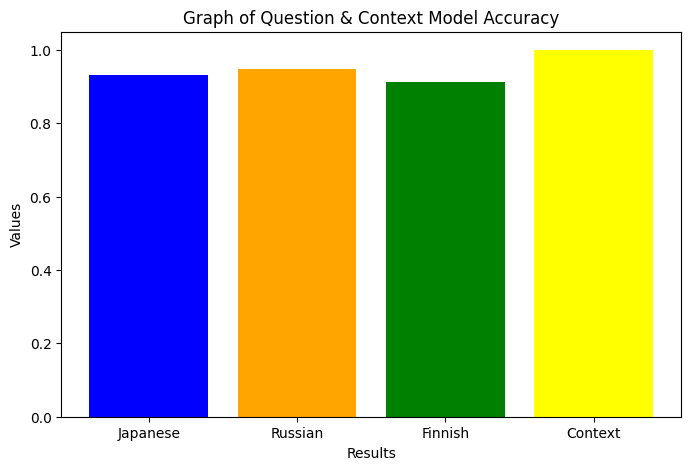

In [ ]:
import matplotlib.pyplot as plt


result1 = validate_model_ja(val_dataloader_ja)
result2 = validate_model_ru(val_dataloader_ru)
result3 = validate_model_fi(val_dataloader_fi)
result4 = validate_model(val_dataloader_context)

results = [result1, result2, result3, result4]
labels = ['Japanese', 'Russian', 'Finnish', 'Context']


plt.figure(figsize=(8, 5))
plt.bar(labels, results, color=['blue', 'orange', 'green', 'yellow'])
plt.xlabel('Results')
plt.ylabel('Values')
plt.title('Graph of Question & Context Model Accuracy')
plt.show()
